## Import libraries

In [84]:
#nbi:hide_in

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import layers
from ipywidgets import interact, widgets
import rpy2.rinterface

In [85]:
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


# Novel samples: prediction of novel ecosystems

In [86]:
# Interface to ask for age, temperature and precipitations3Days (with unit and valid range) 
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html#IntSlider

a = widgets.FloatSlider(min=40,max=100,value=60)
b = widgets.FloatSlider(min=0,max=5,value=1.5)
c = widgets.IntSlider(min=1,max=20,value=4)


accordion = widgets.Accordion(children=[a,b,c])
accordion.set_title(0, 'Temperature (ºF):')
accordion.set_title(1, 'Precipitations 3 days (inches):')
accordion.set_title(2, 'Plant age (weeks):')
accordion

#out = widgets.interactive_output(f, {'a': a, 'b': b, 'c': c})

t = widgets.Label(value="Please, select the environmental features associated to the maize plant/soil to what you would like to predict its rhizosphere microbiome:")

widgets.VBox([t, accordion])





In [88]:
temp=a.value
rain=b.value
age=c.value

In [89]:
metadata = pd.DataFrame({'X.SampleID': ['new01'], 'age': [age], 'Temperature': [temp], 'Precipitation3Days':[rain]}, 
                  columns=['X.SampleID','age','Temperature','Precipitation3Days'])
metadata = metadata.set_index('X.SampleID')
domain = metadata[['age',
                   'Temperature',
                   'Precipitation3Days']]
domain

,age,Temperature,Precipitation3Days
X.SampleID,,,
new01,1,86.7,2.6


In [90]:
metadata.shape

(1, 3)

In [91]:
domain_novel_samples = domain.to_numpy(dtype=np.float32)

#### Load models

In [92]:
decoder = tf.keras.models.load_model('Models/decoder.h5')
encoder_domain = tf.keras.models.load_model('Models/encoder_domain_model_latent.h5')

#### Compute new predictions

In [93]:
# Input only domain (i.e. environmental features)
pred_latent_novel_samples = encoder_domain.predict(domain_novel_samples)
pred_domain_novel_samples = decoder.predict(pred_latent_novel_samples)

In [94]:
def save_predicted_otu_table(pred,sample_names,otu_names,suffix=''):
    df_otu = pd.DataFrame(pred, index=sample_names, columns=otu_names)
    df_otu.T.to_csv('abundances_'+suffix+'.tsv', index=True, header=True, sep='\t')
  
    return df_otu

In [95]:
# Get otu IDs
otu = pd.read_csv('otu_column_otuids.csv', index_col=0, header=None, sep='\t').T
otu = otu.set_index('otuids')
otuids = otu.columns

In [96]:
otuids

Index(['4479944', '513055', '519510', '810959', '849092', '1042671', '818174',
       '585221', '1033380', '875704',
       ...
       '966091', '55354', '515709', '902698', '591499', '569066', '823091',
       '219094', '961783', '823633'],
      dtype='object', name=0, length=717)

In [97]:
df_pred_otu = save_predicted_otu_table(pred_domain_novel_samples,domain.index,otuids,'predicted_otus_novel_features')

In [98]:
pred_domain_novel_samples.shape

(1, 717)

In [99]:
pred_domain_novel_samples

array([[0.0009, 0.    , 0.0023, 0.    , 0.0015, 0.    , 0.002 , 0.    ,
        0.    , 0.0002, 0.0008, 0.    , 0.    , 0.0015, 0.0029, 0.    ,
        0.0012, 0.    , 0.0027, 0.    , 0.0021, 0.0009, 0.    , 0.0024,
        0.0031, 0.0001, 0.0003, 0.0049, 0.0048, 0.0002, 0.0002, 0.0017,
        0.0009, 0.0077, 0.0005, 0.0001, 0.0009, 0.0005, 0.0005, 0.    ,
        0.0008, 0.0014, 0.0002, 0.0006, 0.0051, 0.0009, 0.0002, 0.    ,
        0.0009, 0.0001, 0.0009, 0.0061, 0.    , 0.    , 0.    , 0.0008,
        0.01  , 0.0011, 0.0023, 0.    , 0.    , 0.0006, 0.0049, 0.0005,
        0.    , 0.    , 0.0011, 0.0008, 0.0008, 0.0001, 0.    , 0.    ,
        0.0011, 0.    , 0.0003, 0.    , 0.0002, 0.    , 0.0005, 0.0004,
        0.    , 0.0006, 0.0072, 0.003 , 0.0016, 0.0009, 0.0017, 0.    ,
        0.0225, 0.0006, 0.    , 0.0027, 0.0003, 0.0021, 0.0003, 0.0012,
        0.    , 0.0042, 0.0008, 0.0001, 0.    , 0.    , 0.0004, 0.0075,
        0.0074, 0.0009, 0.    , 0.0001, 0.0005, 0.    , 0.    , 

In [100]:
### TO-DO: call R script to plot some phylosep plot
### To get phyloseq object, taking code from: https://github.com/jorgemf/DeepLatentMicrobiome/blob/master/Src/plot_novel_samples_predictions_radarchart.r
#file_tax = '../Datasets/tax_table_all_80_cleanNames.csv'
#physeq_pred = build_physeq_object('../Results/otus_predFromDomain_novelSamples_byHandAPIvalues.tsv','../Datasets/metadata_novel_samples_byHandAPIvalues_only3envFeatures.csv',file_tax)


In [101]:
%%R
source('Src/functionsR_plotMicrobiome.r')

In [102]:
%Rpush temp rain age

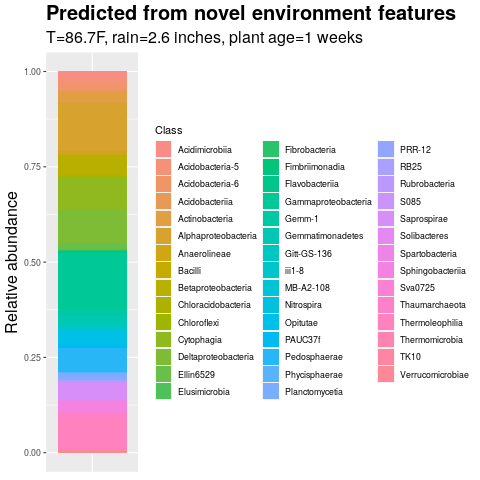

In [105]:
%%R
physeq_pred = build_physeq_object_otu_tax('abundances_predicted_otus_novel_features.tsv','tax_table_cleanNames.csv')
plot_taxa_agg(physeq_pred,"Class",temp,rain,age)